# Accessing the pulse implementation of native gates
All gates are implemented with a sequence of pulses that is carefully calibrated by quantum hardware providers. In this notebook, we will show how to:
- retrieve the calibrations for any particular native gate of interest, 
- modify it 
- submit a circuit where we will overwrite the provider's calibrations and use our modified ones.

These calibrations will be vended as `PulseSequence` objects and will contain a list of low-level instructions that are played in place of the gate that you inserted. Obtaining the accurate sequence that used by the provider offers many opportunities. First, it is one of the best way to understand how quantum computers works at the most fundamental layer. It also allows you to improve the results of your circuits by deploying error mitigation techniques such as zero noise extrapolation by stretching all the pulse of specific gates.

Native gate calibrations are available with Rigetti's Aspen M-3.

First, we will start by initializing a cost tracker and import some libraries.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [2]:
%matplotlib inline

from braket.aws import AwsDevice
from braket.native_gates import NativeGateCalibration
from braket.parametric import FreeParameter
from braket.circuits import Circuit, QubitSet
from braket.circuits.gates import Rx, XY
from braket.circuits.serialization import IRType

import math
from utils.draw_pulse_sequence import draw
import matplotlib.pyplot as plt

Calibrations are associated with a device so we will need to instantiate an AWS device. By default, the device properties are not automatically populated to limit the amount of data downloaded.

In [3]:
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

# Test if the calibrations have been downloaded
print(device._native_gate_calibration is None)

True


Calibrations are accessible via the `native_gate_calibration` field of the device object. When accessed for the first time, the latest calibrations for all the gates will be downloaded. This takes between XX and YY seconds depending on the performance of your internet connection. The calibrations will be then cached as a dictionnary that is indexed by a tuple formed from a gate object and the qubit number.

In [4]:
calibrations = device.native_gate_calibration
print(f"We have downloaded {len(calibrations)} calibrations.")

We have downloaded 925 calibrations.


To refresh the calibration cache, you can run the following method

In [5]:
calibrations = device.refresh_native_gate_calibrations()

Each calibration is represented by a `PulseSequence` object that contains the OpenPulse implementation for the associated native gate. Retrieving a gate in particular can be done by passing the `Gate` object (instantiating with a numerical value or a `FreeParameter` if necessary) and the qubit of interest. For instance, you can inspect the pulse implementation of the XY($\theta$) with the code in next cell.

In [6]:
xy_theta = XY(FreeParameter("theta"))
rx_pi_2 = Rx(math.pi/2)

a=10
b=113
pulse_sequence_xy_theta_q10_q113 = calibrations.get_pulse_sequence((xy_theta, QubitSet([10, 113])))
print(pulse_sequence_xy_theta_q10_q113.to_ir())

OPENQASM 3.0;
cal {
    waveform q10_q113_xy_sqrtiSWAP = {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001453531356869601 + 0.0001369623872355912im, 5.314598054665548e-05 - 0.0008196616498797166im, -0.0023312643930400293 + 0.0016861899028346315im, 0.008331661021180511 + 0.0021600214015805204im, -0.009345414372414592 - 0.01999245936337076im, -0.020869307082315523 + 0.04403273273838273im, 0.09037070563854228 - 0.0229163055060782im, -0.1257970331700826 - 0.09201222595239676im, 0.013668314150123338 + 0.22973925600865466im, 0.2226763770452054 - 0.20759526658228328im, -0.3639865943886201 - 0.04740027410005514im, 0.21911882587722228 + 0.3483835604474336im, 0.13719178405937796 - 0.4161935080501013im, -0.42070438637833935 + 0.1643963182539272im, 0.3997980941199709 + 0.22223613053544505im, -0.08388457201987294 - 0.45174738216248533im, -0.29508108298325064 + 0.35300302297944075im, 0.46024319701889577 + 0.002450099677376259im, -0.29142791756244907 - 0.3562736334944704im, -0.08884776641184942 + 0.451

As you have access to a `PulseSequence` object, you can generate the time trace of this pulse sequence via the `.to_time_trace()` and visualize it with a plotting library like `matplotlib`. We use here a `draw` method that has been placed in a local python file. In the cell below, we draw the pulse sequence for the RX($\pi$/2) gate applied on a qubit 0.

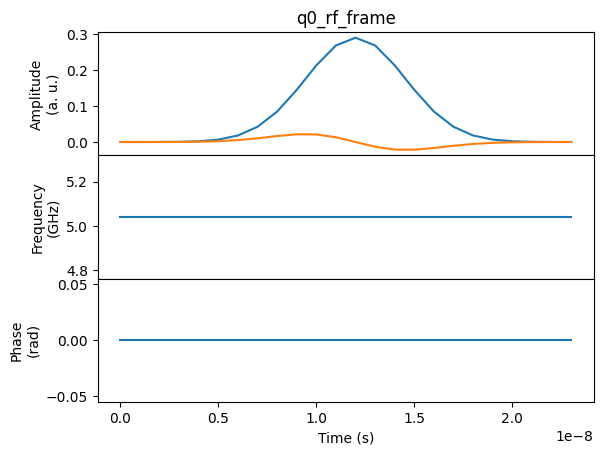

In [7]:
pulse_sequence_rx_pi_2_q0 = calibrations.get_pulse_sequence((rx_pi_2, QubitSet(0)))
draw(pulse_sequence_rx_pi_2_q0)

The fidelity of each gate is reported by Rigetti. It is consultable on the Braket console and programmatically through the device properties:

In [8]:
# method 1
print(f"fidelity of the XY gate between qubits {a} and {b}: ", device.properties.provider.specs["2Q"][f"{a}-{b}"]["fXY"])

# method 2
print(f"fidelity of the XY gate between qubits {a} and {b}: ", calibrations.get_fidelity((xy_theta, QubitSet([10, 113]))))

fidelity of the XY gate between qubits 10 and 113:  0.8248468218281033
fidelity of the XY gate between qubits 10 and 113:  0.8248468218281033


# Attaching calibrations to redefine gates

When submitting a circuit to Rigetti's Aspen M-3 via Braket, all the gates of your circuit will be compiled into native gates, which are ultimately replaced by these sequences of pulses. You can now attach custom-made `PulseSequence`s as calibrations to modify the default behavior.

In [9]:
bell_circuit = Circuit().add_verbatim_box(
    Circuit()
    .rx(0,math.pi/2)
    .rx(1,math.pi/2)
    .cz(0,1)
    .rx(1,-math.pi/2)
)
print(bell_circuit)

T  : |      0      |   1    |2|    3    |     4     |
                                                     
q0 : -StartVerbatim-Rx(1.57)-C-----------EndVerbatim-
      |                      |           |           
q1 : -*************-Rx(1.57)-Z-Rx(-1.57)-***********-

T  : |      0      |   1    |2|    3    |     4     |


Text(0, 0.5, 'Population')

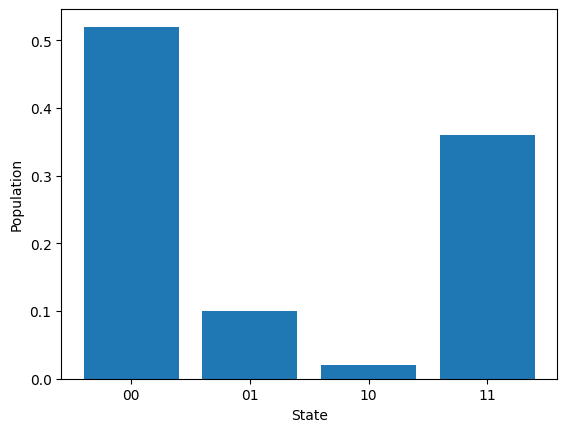

In [10]:
nb_shots = 50
task=device.run(bell_circuit, shots=nb_shots)

counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

Attaching the calibrations that we have downloaded in one of the first cell of this notebook, we can submit again the same circuit and see that we do not have significant changes compared to the first circuit execution

Text(0, 0.5, 'Population')

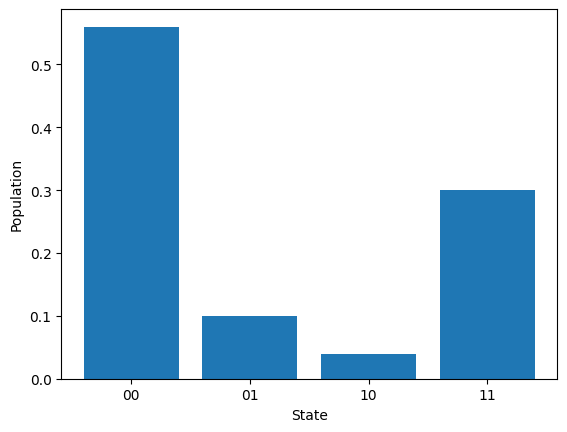

In [11]:
custom_calibration = NativeGateCalibration({(Rx(math.pi/2), QubitSet(0)): pulse_sequence_rx_pi_2_q0})
task=device.run(bell_circuit, native_gate_calibration=custom_calibration, shots=nb_shots)

counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

In [12]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 100, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.635 USD
